In [1]:
import os

import pysnnblaze as pb
import numpy as np
import time
import random
import math
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

## Funções auxiliares

In [2]:
def plot_3d_network(positions, graph, inh_neurons, neuron_size=20, connection_alpha=0.3):
    """
    Plots a 3D neural network graph.

    Args:
        positions (dict): neuron positions {index: (x, y, z)}
        graph (list): list of connections [(pre, post, weight, delay), ...]
        num_inhibitory (int, optional): number of inhibitory neurons at the end of the list
        neuron_size (int): size of neuron scatter points
        connection_alpha (float): transparency of connection lines
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    total_neurons = len(positions)
        
    # Plot neurons
    inh_label_added = False
    exc_label_added = False

    for idx, (x, y, z) in positions.items():
        if idx in inh_neurons:
            label = 'Inibitórios' if not inh_label_added else ""
            ax.scatter(x, y, z, c='blue', s=neuron_size, label=label, marker='^')
            inh_label_added = True
        else:
            label = 'Excitatórios' if not exc_label_added else ""
            ax.scatter(x, y, z, c='red', s=neuron_size, label=label)
            exc_label_added = True


    # Plot connections
    for pre, post, weight, delay in graph:
        x_vals = [positions[pre][0], positions[post][0]]
        y_vals = [positions[pre][1], positions[post][1]]
        z_vals = [positions[pre][2], positions[post][2]]

        color = 'red' if weight > 0 else 'blue'
        ax.plot(x_vals, y_vals, z_vals, c=color, alpha=connection_alpha, linewidth=1)

    # Labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Rede Neural 3D')

    # Set integer ticks for all axes
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.zaxis.set_major_locator(MaxNLocator(integer=True))

    ax.legend()
    plt.show()

def plot_raster(spikes, title="Raster Plot", last_reservoir_index=None, dpi=100):
    # Unpack spikes into separate lists
    time = spikes[:,0]
    neurons = spikes[:,1]

    plt.figure(figsize=(10, 6), dpi=dpi)
    plt.scatter(time, neurons, s=1, c='black')

    # Add horizontal line and labels if last_reservoir_index is given
    if last_reservoir_index is not None:
        plt.axhline(last_reservoir_index + 0.5, color='red', linestyle='--', linewidth=1)
        plt.text(time.max()+0.02, last_reservoir_index-num_neurons*0.03, "Neurônios do reservatório", color='black', fontsize=10, va='center')
        plt.text(time.max()+0.02, last_reservoir_index+num_neurons*0.03, "Neurônios de entrada", color='black', fontsize=10, va='center')
        plt.xlim([0, time.max() + 0.25])

    plt.xlabel("Tempo (s)", fontsize=14)
    plt.ylabel("Neurônio", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(title)
    plt.show()

def subsample_spikes(spike_events_set, subsampling):
    subs_spike_events_set = []
    for spike_events in spike_events_set:
        subsampled_events = spike_events
        subsampled_events[:, 1] = subsampled_events[:, 1]//subsampling
        subs_spike_events_set.append(subsampled_events)
    return subs_spike_events_set

def build_input_layer(num_in, num_res, in_slice_start, res_slice_start, p_res_input, num_inp_to_res, weight_range, delay_range):
    '''
    Builds a graph connecting input neurons to reservoir neurons.
    The first reservoir neuron index must be specified (reservoir and input neurons must occupy a continuous slice of neurons).
    '''
    inp_graph = []
    num_targets = int(p_res_input * num_res)

    valid_res_neurons = np.random.choice(num_res, size=num_targets, replace=False)

    for i in range(num_in):
        selected_res_neurons = np.random.choice(valid_res_neurons, size=num_inp_to_res, replace=False)
        for j in selected_res_neurons:
            weight = np.random.uniform(weight_range[0], weight_range[1]) # C
            delay = np.random.uniform(delay_range[0], delay_range[1])  # ms
            inp_graph.append((in_slice_start+i, res_slice_start + j, weight, delay))

    return inp_graph

def input_to_reservoir(nn, spike_events, in_slice_start):
    '''
    nn: snnblaze NeuralNetwork instance
    spike_events: array of shape (num_spikes, 2) with columns [spike_time, neuron_index]
    '''
    for spike_time, neuron_index in spike_events:
        nn.schedule_spike_event(spike_time, int(in_slice_start+neuron_index), weight)

def convolve_spikes_exponential(spike_list, num_neurons, dt=0.001, tau=0.02, t_start=0, t_interval=None):
    if not spike_list:
        raise ValueError("Spike list is empty.")
    
    # Filtering according to start time
    spike_list = [spike for spike in spike_list if spike[0] >= t_start]

    if t_interval is None:
        t_interval = spike_list[-1][0] - t_start # The simulator outputs sorted spike times
    
    # Determine dimensions
    times = np.arange(0, t_interval, dt)
    rates = np.zeros((num_neurons, len(times)))
    
    # Exponential kernel (causal)
    kernel_length = int(5 * tau / dt)  # 5*tau cutoff
    kernel_t = np.arange(0, kernel_length * dt, dt)
    kernel = np.exp(-kernel_t / tau)
    
    # Fill spike trains and convolve
    for t, n in spike_list:
        idx = int((t-t_start) / dt)
        if idx < len(times):
            rates[n, idx] += 1.0 / dt  # convert spike to impulse
    
    for n in range(num_neurons):
        rates[n] = np.convolve(rates[n], kernel, mode='full')[:len(times)]
    
    return rates

## Construção de uma rede neural complexa - Rede Bioinspirada
Esta rede inspira-se no trabalho de Maas et al. (2002), buscando imitar a organização de redes biológicas por meio de uma estrutura tridimensional e de uma regra de conectividade local.

In [3]:
# Parâmetros do neurônio
tau_m = 100e-3
C_m = 200e-12
v_rest = -70e-3
v_reset = -70e-3
v_thresh = -50e-3
refractory = 2e-3

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

In [4]:
# Parâmetros da rede
weight_range_exc = (2.0e-3*C_m, 6.0e-3*C_m)
weight_range_inh = (-12.0e-3*C_m, -4.0e-3*C_m)
network_shape = (5, 5, 5)  # 3D lattice dimensions (x, y, z)
num_neurons = network_shape[0]*network_shape[1]*network_shape[2]
num_inhibitory = int(0.2 * num_neurons)
delay_scale_factor = 5.0e-3  # scale factor for delays

lambda_EE = 2.0
lambda_EI = 2.0
lambda_IE = 2.0
lambda_II = 2.0

C_EE = 0.3
C_EI = 0.2
C_IE = 0.4
C_II = 0.0

# Estrutura tridimensional
positions = {}
i = 0
for x in range(network_shape[0]):
    for y in range(network_shape[1]):
        for z in range(network_shape[2]):
            positions[i] = (x, y, z)
            i += 1

# Probabilidade de conexão baseada em distância (Maas et al.)
def connection_probability(d, lambda_val, C):
    return C*math.exp(-(d ** 2)/(lambda_val ** 2))

random.seed(42)
all_neurons = list(range(num_neurons))
inh_neurons = set(random.sample(all_neurons, num_inhibitory))
exc_neurons = set(all_neurons) - inh_neurons

# Construindo o grafo da rede
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            x1, y1, z1 = positions[pre]
            x2, y2, z2 = positions[post]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

            if pre in exc_neurons and post in exc_neurons:
                lambda_conn = lambda_EE
                C_conn = C_EE
            elif pre in exc_neurons and post in inh_neurons:
                lambda_conn = lambda_EI
                C_conn = C_EI
            elif pre in inh_neurons and post in exc_neurons:
                lambda_conn = lambda_IE
                C_conn = C_IE
            else: 
                lambda_conn = lambda_II
                C_conn = C_II

            prob = connection_probability(dist, lambda_conn, C_conn)
            if random.random() < prob:
                weight = random.uniform(*weight_range_inh) if pre in inh_neurons else random.uniform(*weight_range_exc)
                delay = dist*delay_scale_factor
                graph.append((pre, post, weight, delay))

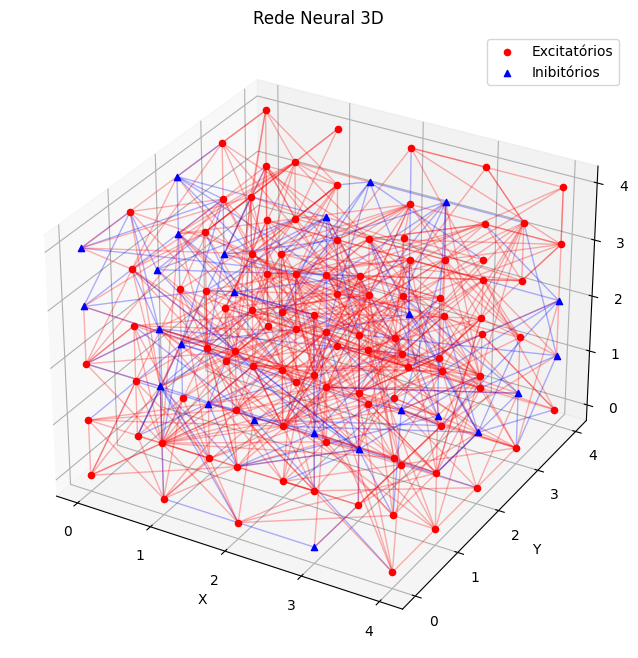

In [5]:
# Exibindo a rede
plot_3d_network(positions, graph, inh_neurons)

## Importando o dataset SHD

In [6]:
shd_train_filepath = '../data/shd_train.h5'
shd_train_filepath = '../data/shd_test.h5'

with h5py.File('../data/shd_train.h5', 'r') as f:
    print("Top-level groups/datasets:", list(f.keys()))
    print(f['labels']) # Classes
    print(f['spikes/times']) # Spike times
    print(f['spikes/units']) # Neuron indices

    train_labels = f['labels'][:]
    train_spike_times = f['spikes/times'][:]
    train_neuron_indices = f['spikes/units'][:]

with h5py.File('../data/shd_test.h5', 'r') as f:
    test_labels = f['labels'][:]
    test_spike_times = f['spikes/times'][:]
    test_neuron_indices = f['spikes/units'][:]

train_spike_events = []
test_spike_events = []

for i in range(train_spike_times.shape[0]):
    events = np.stack((train_spike_times[i], train_neuron_indices[i]), axis=-1)
    train_spike_events.append(events)

for i in range(test_spike_times.shape[0]):
    events = np.stack((test_spike_times[i], test_neuron_indices[i]), axis=-1)
    test_spike_events.append(events)

Top-level groups/datasets: ['extra', 'labels', 'spikes']
<HDF5 dataset "labels": shape (8156,), type "<u2">
<HDF5 dataset "times": shape (8156,), type "|O">
<HDF5 dataset "units": shape (8156,), type "|O">


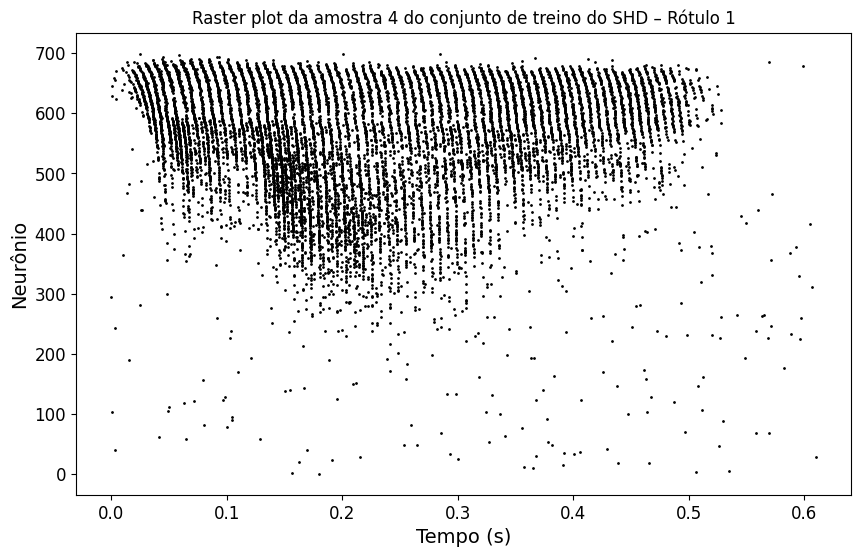

In [7]:
sample = 4
plot_raster(train_spike_events[sample], title=f'Raster plot da amostra {sample} do conjunto de treino do SHD – Rótulo {train_labels[sample]}')

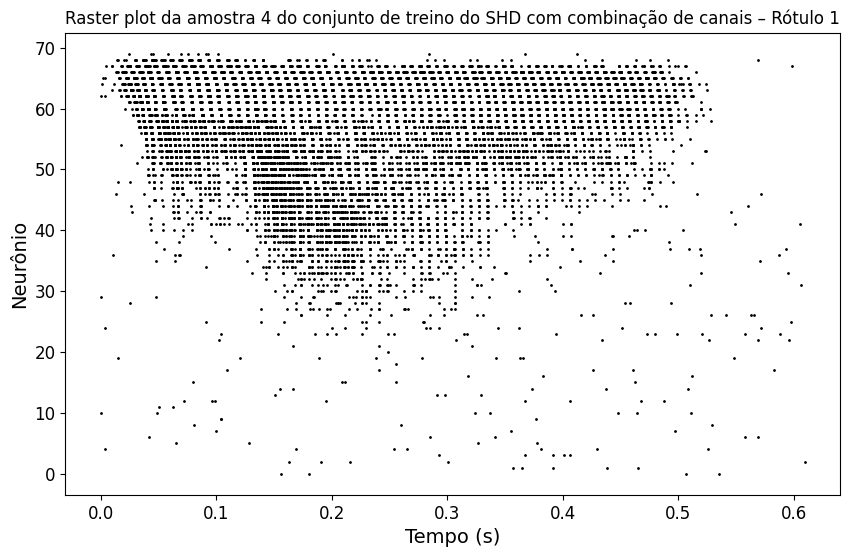

In [24]:
subsampling = 10
train_spike_events = subsample_spikes(train_spike_events, subsampling)

plot_raster(train_spike_events[sample], title=f'Raster plot da amostra {sample} do conjunto de treino do SHD com combinação de canais – Rótulo {train_labels[sample]}')

### Simulating network and retrieving results

In [25]:
# Criando a rede neural com base no grafo
start_time = time.perf_counter()
nn = pb.NeuralNetwork()
spike_monitor = pb.SpikeMonitor()
nn.set_spike_monitor(spike_monitor)
nn.add_neuron_population(num_neurons, neuron) # reservoir neurons

for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

end_time = time.perf_counter()
print(f"Setup finished in {end_time - start_time:.6f} seconds")

Setup finished in 0.001157 seconds


In [26]:
# Adicionando a camada de entrada
num_shd_inputs = 700 // subsampling

inp_graph = build_input_layer(
    num_in=num_shd_inputs,
    num_res=num_neurons,
    in_slice_start=num_neurons,
    res_slice_start=0,
    p_res_input=1,
    num_inp_to_res=5,
    weight_range=(30e-3*C_m, 30e-3*C_m),
    delay_range=(0.1e-3, 0.1e-3)
)

inp_neuron = pb.InputNeuron()
nn.add_neuron_population(num_shd_inputs, inp_neuron)

for pre, post, weight, delay in inp_graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

Run finished in 0.030480 seconds


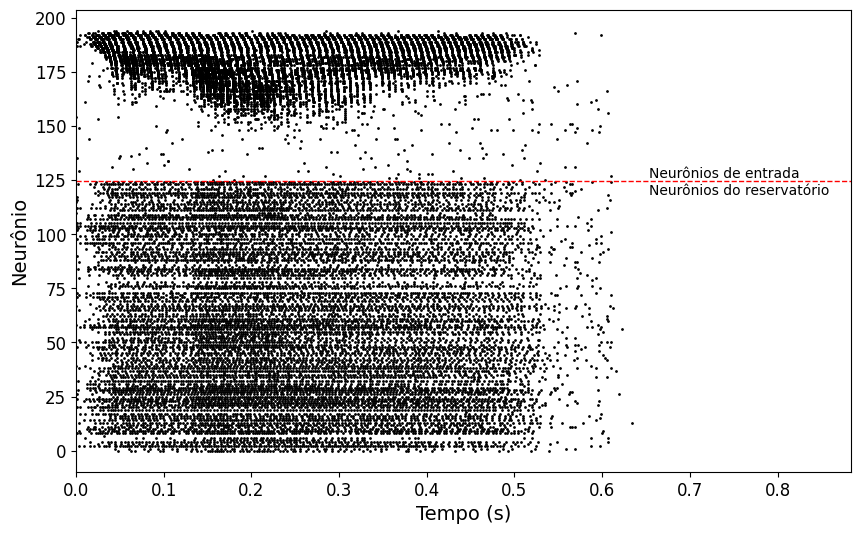

In [27]:
# Fornecendo a entrada para a rede
input_to_reservoir(nn, train_spike_events[sample], in_slice_start=num_neurons)

# Simulando a resposta por 1 segundo
start_time = time.perf_counter()
nn.run(1.0)
end_time = time.perf_counter()
print(f"Run finished in {end_time - start_time:.6f} seconds")

plot_raster(np.array(spike_monitor.spike_list), title=f'', last_reservoir_index=num_neurons-1)